# HANDL 

The goal of HANDL is to support the transfer of biological knowledge across species.  It does so by constructing explicit measures of functional similarity between proteins in different species.   HANDL (Homology Assessment across Networks using Diffusion and Landmarks) creates a functional embedding in which proteins from different species are embedded in the same vector space. In the paper [1] it is shown that inner products in this space _(HANDL homology scores)_, as well as the vectors themselves _(HANDL embeddings)_, capture functional similarity across species and are useful for a variety of functional tasks.

[1] [A Multi-Species Functional Embedding Integrating Sequence and
Network Structure](https://www.biorxiv.org/content/early/2017/12/04/229211), Mark D.M. Leiserson, Jason Fan, Anthony Cannistra, Inbar Fried, Tim Lim, Thomas Schaffner, Mark Crovella, and Benjamin Hescott, _Proceedings of RECOMB 2018,_ Paris, France.

## Background

An overview of HANDL is shown in the figure below.  Starting with a source and a target network, HANDL computes diffusion kernels for each network. The diffusion kernels are factored, resulting in a representation in which each node becomes a vector, and inner products correlate with functional similarities. HANDL then solves a linear system to create a single embedding of both vector sets, allowing for functional comparisons between proteins across the two networks.

![HANDL Overview](figures/handl-methods.jpg)

As shown in the figure, HANDL works with the notion of a _source_ species and one or more _target_ species.  The proteins of the target species are embedded into a space defined by the source species.

## This workbook

This workbook illustrates how to compute HANDL embeddings and HANDL homology scores as described in [1].  As a demonsration, we compute functional similarity between proteins in _S. cerevisiae_ (Sc) and _S. pombe_ (Sp).

## Configuration 

This workbook assumes that the [HANDL demo repository](https://github.com/theJasonFan/HANDL) has been downloaded, and that data has been retrieved and prepared as described in the __Data__ section of the [README](https://github.com/theJasonFan/HANDL/blob/master/README.md).

In [1]:
import numpy as np
import networkx as nx
import scipy
import sklearn
import sklearn.neighbors
import matplotlib.pyplot as plt

%matplotlib inline

Some of the functions we will use are in associated libraries.

In [2]:
import sys
sys.path.append('../src')
import util
from handl import regularized_laplacian, rkhs_factor

Configuration parameters:
* `source`: Source species
* `target`: Target species
* `lam`: Value of $\lambda$ used in computing the Regularized Laplacian
* `data_dir`: Directory holding all data
* `n_landmarks`: Number of landmarks to use in constructing the embedding 

In [3]:
source = 'sc'
target = 'sp'
lam = 0.05
data_dir = '../data'
n_landmarks = 400

## HANDL embedding

The first stage of the HANDL embedding involves the following steps:

1. Construct PPI networks for source and target species
2. Reduce each network to its 2-core (see paper for explanation).
3. Compute the Laplacian $L$ and Regularized Laplacian $D = (I + \lambda L)^{-1}$ for each species.
4. Factor the Regularized Laplacian to get HANDL embedding vectors $D = CC^T$.

In [4]:
nodes = {}
D = {}
C = {}

for species in [source, target]:
    ppi_edgelist = '{}/ppi/biogrid/{}/{}-biogrid.v3.4.157-ppi-std.tsv'.format(
        data_dir, species, species)
    G = nx.read_edgelist(ppi_edgelist, encoding='ascii')
    G = util.simple_two_core(G)
    nodes[species] = sorted(G.nodes())
    D[species] = regularized_laplacian(G, nodes[species], lam)
    C[species] = rkhs_factor(D[species])

2018-02-20 16:37:54,513 util.py         INFO      : PPI info - # Nodes: 5751, # Edges: 96139
2018-02-20 16:37:54,514 util.py         INFO      : Computing 2 core
2018-02-20 16:37:56,150 util.py         INFO      : 2 core info - # Nodes: 5609, # Edges: 95997
2018-02-20 16:37:56,152 util.py         INFO      : 2 core removed 142 nodes and 142 edges
2018-02-20 16:42:22,324 util.py         WARNING   : Network has 109 connected components
2018-02-20 16:42:22,325 util.py         WARNING   : 	Largest is size 2678 and all the rest are 6 or smaller
2018-02-20 16:42:22,325 util.py         WARNING   : 	Using largest connected component
2018-02-20 16:42:22,333 util.py         INFO      : PPI info - # Nodes: 2678, # Edges: 8525
2018-02-20 16:42:22,335 util.py         INFO      : Computing 2 core
2018-02-20 16:42:22,512 util.py         INFO      : 2 core info - # Nodes: 1865, # Edges: 7712
2018-02-20 16:42:22,513 util.py         INFO      : 2 core removed 813 nodes and 813 edges


The second stage of the HANDL embedding uses known homologs between the two species.  First we read in the set of all known homologs.

In [5]:
# assume the order in homolog file is source node, target node
homolog_list = '{}/homologs/sc-sp/sc-sp-homologs.txt'.format(
    data_dir)
source_homs = []
target_homs = []
with open(homolog_list, 'r') as hom_f:
    for line in hom_f:
        source_hom, target_hom = line.split()
        if (source_hom in nodes[source]) and (target_hom in nodes[target]):
            source_homs.append(source_hom)
            target_homs.append(target_hom)

Next we choose a subset of homologs to use as landmarks.   In this case we simply take the initial `n_landmarks` (using no particular selection criterion).

In [6]:
source_homolog_indices = [nodes[source].index(node) for node in source_homs]
target_homolog_indices = [nodes[target].index(node) for node in target_homs]
source_landmarks = source_homs[:n_landmarks]
target_landmarks = target_homs[:n_landmarks]

source_landmark_indices = source_homolog_indices[:n_landmarks]
source_non_landmark_indices = source_homolog_indices[n_landmarks:]
target_landmark_indices = target_homolog_indices[:n_landmarks]
target_non_landmark_indices = target_homolog_indices[n_landmarks:]

Finally we construct the embedding of the target species in the source vector space.  As described in the paper, this is done by treating the diffusion scores to landmarks in the target species ($D_{2L}$) as if they applied to the landmarks in the source species.  This implies the linear system
$$ D_{2L} = C_{1L} \hat{C_2}^T $$
which we solve via 
$$ \hat{C_2}^T = C_{1L}^\dagger D_{2L} $$
yielding the embedding for the nodes in the target network $\hat{C_2}^T$.

In [7]:
target_handl_C = np.linalg.pinv(C[source][source_landmark_indices,:]).dot(
    D[target][target_landmark_indices,:])

## HANDL homology scores

Finally we construct the HANDL homology scores by simply taking the inner products of the corresponding embedding vectors:
$$ D_{12} = C_1 \hat{C_2}^T.$$

In [26]:
D_cross_species = C[source].dot(target_handl_C)

## Plot homolog density

As a demonstration, we show that homologs have distinct HANDL homology scores.   This plot corresponding to Figure 2(b) from [1].

For visualization purposes we work with normalized dissimilarities:

In [33]:
Dissim = 1./D_cross_species
Dissim_matrix = Dissim / np.mean(Dissim)

We aren't interested in the homologs that were used as landmarks, so we remove those entries from the HANDL homology score matrix.

In [34]:
def seperate_dissimilarity_scores(dissim_scores, 
                                  source_landmark_idxs, 
                                  source_NLH_idxs,
                                  target_landmark_idxs,
                                  target_NLH_idxs):
    # Obtain non-landmark homolog scores
    mask = np.zeros_like(dissim_scores, dtype=np.bool)
    mask[source_NLH_idxs, target_NLH_idxs] = True
    NLH_scores = dissim_scores[mask]
    
    # Obtain non-homolog scores, 
    # excluding all rows and columns corresponding to landmarks
    mask = np.ones_like(dissim_scores, dtype=np.bool)
    mask[source_landmark_idxs, :] = False
    mask[:, target_landmark_idxs] = False
    mask[source_NLH_idxs, target_NLH_idxs] = False
    non_homolog_scores = dissim_scores[mask]

    return NLH_scores, non_homolog_scores

In [48]:
def seperate_dissimilarity_scores2(dissim_scores, 
                                  landmark_pair_idxs, homolog_pair_idxs):
    source_landmark_idxs, target_landmark_idxs = zip(*landmark_pair_idxs)
    source_homolog_idxs, target_homolog_idxs = zip(*homolog_pair_idxs)
    landmark_mask = np.zeros_like(dissim_scores, dtype=bool)
    landmark_mask[source_landmark_idxs, target_landmark_idxs] = True
    
    homolog_mask = np.zeros_like(dissim_scores, dtype=bool)
    homolog_mask[source_homolog_idxs, target_homolog_idxs] = True
    
    # Obtain non-landmark homolog scores
    nlh_mask = np.ones_like(dissim_scores, dtype=np.bool)
    nlh_mask &= homolog_mask # all homologs
    nlh_mask &= ~landmark_mask # all not landmarks
    NLH_scores = dissim_scores[nlh_mask]
    
    # Obtain non-homolog scores, 
    # excluding all rows and columns corresponding to landmarks
    other_mask = np.ones_like(dissim_scores, dtype=bool)
    other_mask &= ~homolog_mask # all not homologs
    other_mask &= ~landmark_mask # all not landmarks
    non_homolog_scores = dissim_scores[other_mask]

    return NLH_scores, non_homolog_scores

In [36]:
def plot(NLH, D, xmax=0.6, font_size=12, line_width=2):
    from sklearn import neighbors
    # create kernel density estimator
    kde = neighbors.KernelDensity(kernel='gaussian',
                                              bandwidth = xmax / 20.)
    # need to add another dimension as required by sklearn
    # arrays passed to kde must be 2-dimensional
    X_plot = np.reshape(np.linspace(0, xmax, 500), (-1, 1))

    # Density of non-landmark homolog pairs
    kde.fit(np.reshape(np.ravel(NLH), (-1, 1)))
    NLHdens = kde.score_samples(X_plot)

    # Density of all pairs
    Dsamp = np.random.choice(np.ravel(D),100000)
    kde.fit(np.reshape(Dsamp, (-1, 1)))
    Ddens = kde.score_samples(X_plot)

    # create plot
    plt.figure()
    plt.plot(X_plot[:,0], np.exp(NLHdens), lw = line_width,
                 label = 'Homolog Pairs')
    plt.plot(X_plot[:,0], np.exp(Ddens), '-.',
                 lw = line_width, ls = (0,(5,2)), label = 'Non-homolog Pairs')
    plt.ylabel('Density', size = font_size)
    plt.xlabel('HANDL dissimilarity', size = font_size)
    plt.legend(loc='best', fontsize = font_size)

In [37]:
print(Dissim.shape)
NLH, Dissim = seperate_dissimilarity_scores(
                Dissim_matrix, 
                source_landmark_indices,
                source_non_landmark_indices,
                target_landmark_indices,
                target_non_landmark_indices)

(5609, 1865)


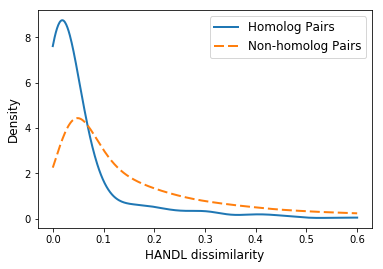

In [38]:
plot(NLH, Dissim)

In [39]:
import handl

In [40]:
source_C, target_C_hat = handl.handl_embed_matrices(C[source], D[target], zip(source_landmark_indices, target_landmark_indices))

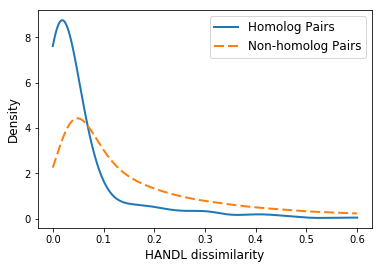

In [42]:
D_xs = source_C.dot(target_C_hat.T)
Dissim2 = 1./D_xs
Dissim2 = Dissim2 / np.mean(Dissim2)
NLH2, Dissim2 = seperate_dissimilarity_scores(
                Dissim2, 
                source_landmark_indices,
                source_non_landmark_indices,
                target_landmark_indices,
                target_non_landmark_indices)
plot(NLH2, Dissim2)

In [44]:
G = {}
for species in [source, target]:
    ppi_edgelist = '{}/ppi/biogrid/{}/{}-biogrid.v3.4.157-ppi-std.tsv'.format(
        data_dir, species, species)
    G[species] = util.simple_two_core(nx.read_edgelist(ppi_edgelist, encoding='ascii'))

2018-02-20 16:58:27,945 util.py         INFO      : PPI info - # Nodes: 5751, # Edges: 96139
2018-02-20 16:58:27,947 util.py         INFO      : Computing 2 core
2018-02-20 16:58:29,636 util.py         INFO      : 2 core info - # Nodes: 5609, # Edges: 95997
2018-02-20 16:58:29,637 util.py         INFO      : 2 core removed 142 nodes and 142 edges
2018-02-20 16:58:29,992 util.py         WARNING   : Network has 109 connected components
2018-02-20 16:58:29,992 util.py         WARNING   : 	Largest is size 2678 and all the rest are 6 or smaller
2018-02-20 16:58:29,993 util.py         WARNING   : 	Using largest connected component
2018-02-20 16:58:30,001 util.py         INFO      : PPI info - # Nodes: 2678, # Edges: 8525
2018-02-20 16:58:30,001 util.py         INFO      : Computing 2 core
2018-02-20 16:58:30,147 util.py         INFO      : 2 core info - # Nodes: 1865, # Edges: 7712
2018-02-20 16:58:30,148 util.py         INFO      : 2 core removed 813 nodes and 813 edges


In [45]:
((source_C, source_nodes), (target_C_hat, target_nodes), landmark_idxs, homolog_idxs) = \
    handl.handl_embed_graphs(G[source], G[target], list(zip(source_homs, target_homs)), 400, lam=0.05, return_idxs=True)

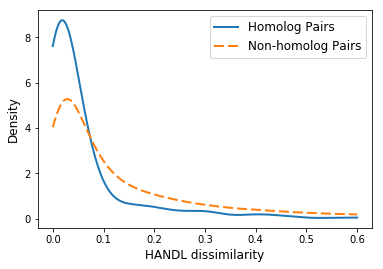

In [49]:
D_xs = source_C.dot(target_C_hat.T)
Dissim3 = 1./D_xs
Dissim3 = Dissim3 / np.mean(Dissim3)
s_l_idxs, t_l_idxs = zip(*landmark_idxs)
s_nlh_idxs, t_nlh_idxs = zip(*homolog_idxs)
NLH3, Dissim3 = seperate_dissimilarity_scores2(
                Dissim3, 
                landmark_idxs,
                homolog_idxs)
plot(NLH3, Dissim3)